In [2]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('../')

import h5py
import scipy
import sympy
import pickle
import numpy as np
from tqdm import tqdm
from pathlib import Path
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix
from sympy import Symbol, zeros, Function, MatrixSymbol

# import created modules
from hamiltonian.states import CoupledBasisState
from hamiltonian.generate_hamiltonian import generate_X_hamiltonian_function, generate_B_hamiltonian_function, \
                                                generate_diagonalized_hamiltonian
from hamiltonian.utils import ni_range, matrix_to_states, find_exact_states, reduced_basis_hamiltonian, \
                                find_state_idx_from_state, reorder_evecs, generate_coupled_ground_states

from couplings.utils import ED_ME_mixed_state, collapse_matrices, generate_superoperator, \
                            generate_flat_superoperator, generate_sharp_superoperator
from couplings.generate_coupling import optical_coupling_matrix, generate_laser_D

from symbolic import generate_density_matrix_symbolic, generate_system_of_equations, generate_symbolic_hamiltonian,\
                        system_of_equations_to_lines, generate_symbolic_detunings
from symbolic.utils import subs_rabi_rate

from utils.plot_utils import set_fontsize
from utils import population, J_levels, J_slice, delete_J_level

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
script_dir = Path().parent.absolute().parent

In [10]:
script_dir

WindowsPath('C:/Users/Olivier/Documents/GitHub/optical-bloch')

## X-state

Define what states from the $X ^1\Sigma$ electronic state are to be included in the simulation.

In [13]:
#Define what states are to be included in the simulation
Js_g = [0,1,2,3] # J values to be included
I_F = 1/2 #Fluorine nuclear spin
I_Tl = 1/2 #Thallium nuclear spin

#Generate a list of approximate ground states. The exact ground states are determined within the main
#simulation function
ground_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                  for J  in Js_g
                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                  for mF in ni_range(-F, F+1)
                 ]

In [14]:
for s in ground_states_approx:
    s.print_state()

+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 0, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 0, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 1/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 0>
+1.0000+0.0000j x |X, J = 1, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/

Now generate the J=0 to J=4 Hamiltonian to get the reduced X state Hamiltonian

In [15]:
fname_X = "TlF_X_state_hamiltonian_J0to4.pickle"
fname_transform = "UC_to_C_J0to4.pickle"

path_X = script_dir / "stored_data" / fname_X
path_transform = script_dir / "stored_data" / fname_transform

with open(path_X, 'rb') as f:
    H_X_uc = pickle.load(f)

with open(path_transform, 'rb') as f:
    S_transform = pickle.load(f)

H_X_uc = generate_X_hamiltonian_function(H_X_uc)

In [16]:
parity = lambda J: (-1)**J

# generate coupled basis states
Jmin = 0
Jmax = 4
QN_X = generate_coupled_ground_states(ni_range(Jmin, Jmax + 1), electronic_state = 'X',
                                       parity = parity, Ω = 0, I_Tl = 1/2, 
                                       I_F = 1/2)

E = np.array([0,0,0])
# small magnetic field to ensure m_F is a good quantum number
B = np.array([0,0,0.001])

H_X = S_transform.conj().T @ H_X_uc(E,B) @ S_transform

# diagonalize the Hamiltonian
H_X_diag, V, V_ref_X = generate_diagonalized_hamiltonian(H_X, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_X_diag = matrix_to_states(V, QN_X)

ground_states = find_exact_states(ground_states_approx, H_X_diag, QN_X_diag, V_ref = V_ref_X)

H_X_red = reduced_basis_hamiltonian(QN_X_diag, H_X_diag, ground_states)

## B-state
Define what states from the $B ^3\Pi_1$ electronic state are to be included in the simulation.

In [119]:
I_F = 1/2
I_Tl = 1/2

# define what states are to be included in the simulation
# specify J, F1 and F for each state separately
J_excited = [1]
F1_excited = [3/2]
F_excited = [2]

# generate a list of excited states. The exact excited states are determined within the main
# simulation function
excited_states_approx = [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='B', P = -1, Omega = 1)
                  for J,F1,F in zip(J_excited, F1_excited, F_excited)
                  for mF in ni_range(-F, F+1)
                 ]

In [120]:
for s in excited_states_approx:
    s.print_state()

+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = -2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = -1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 0, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 2, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


Now generate the excited state Hamiltonian to get the reduced B state Hamiltonian

In [121]:
fname_B = "B_hamiltonians_symbolic_coupled_P_1to3.pickle"

path_B = script_dir / "stored_data" / fname_B

In [122]:
with open(path_B, 'rb') as f:
    H_B = pickle.load(f)

In [123]:
H_B = generate_B_hamiltonian_function(H_B)*2*np.pi

# generate coupled basis states
Jmin = 1
Jmax = 3
Ps = [-1,1]

QN_B = [CoupledBasisState(
                    F,mF,F1,J,I_F,I_Tl,P = P, Omega = 1, electronic_state='B'
                    )
        for J  in ni_range(Jmin, Jmax+1)
        for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
        for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
        for mF in ni_range(-F, F+1)
        for P in Ps
    ]


H_B_diag, V, V_ref_B = generate_diagonalized_hamiltonian(H_B, keep_order = True, return_V_ref = True)

# new set of quantum numbers:
QN_B_diag = matrix_to_states(V, QN_B)

excited_states = find_exact_states(excited_states_approx, H_B_diag, QN_B_diag, V_ref=V_ref_B)

H_B_red = reduced_basis_hamiltonian(QN_B_diag, H_B_diag, excited_states)

## Total Internal Hamiltonian

In [124]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; P(2), F$_1$'=3/2, F'=2

In [126]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [134]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=2,F1=3/2,F=1,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = +1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=1,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [135]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [136]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0
H_laser_z_1[np.abs(H_laser_z_1) < 1e-6] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-6] = 0

In [138]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(-0.07693482677091049+0j)
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+1.0000+0.0000j x |X, J = 2, F1 = 3/2, F = 1, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.8482+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5294+0.0000j x |B, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [139]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

In [140]:
H_laser_z_1[np.nonzero(H_laser_z_1)]

array([ 0.07694618+0.j,  0.08884324+0.j,  0.07693483+0.j, -0.26184444+0.j,
       -0.13091975+0.j,  0.1309236 +0.j,  0.26184227+0.j,  0.13730046+0.j,
        0.06863883+0.j, -0.06867255+0.j, -0.13732231+0.j,  0.29974792+0.j,
        0.3791519 +0.j,  0.40214859+0.j,  0.37914676+0.j,  0.29973981+0.j,
       -0.26184444+0.j,  0.13730046+0.j,  0.29974792+0.j,  0.07694618+0.j,
       -0.13091975+0.j,  0.06863883+0.j,  0.3791519 +0.j,  0.08884324+0.j,
        0.40214859+0.j,  0.07693483+0.j,  0.1309236 +0.j, -0.06867255+0.j,
        0.37914676+0.j,  0.26184227+0.j, -0.13732231+0.j,  0.29973981+0.j])

## Total Hamiltonian

In [141]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1

In [142]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.28it/s]


## Generate Symbolic Hamiltonian

In [143]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1)]
detunings = [[QN.index(excited_states[0])]]

In [144]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [147]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])

In [148]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [43:22<00:00, 45.66s/it]


In [149]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

# Solving ODE system with Julia
Need to install Julia and add the following packages to Julia:  
* [DifferentialEquations](https://diffeq.sciml.ai/stable/)
* [Trapz](https://github.com/francescoalemanno/Trapz.jl)

And install [PyJulia](https://pyjulia.readthedocs.io/en/latest/index.html) for python.  

In [150]:
# import julia
# julia.install()

In [151]:
from julia import Main

In [155]:
Main.eval("""
using Distributed
using BenchmarkTools
""")

procs = Main.eval("nprocs()")
if procs < 6:
    Main.eval(f"""
    addprocs({6-procs})
    @everywhere begin
        using LinearAlgebra
        using Trapz
        using DifferentialEquations
        include("../utils/general_ode_functions.jl")
    end""")
if procs > 6:
    procs = Main.eval("procs()")
    for proc in procs[procs > 6]:
        Main.eval(f"rmprocs({proc})")
print(Main.eval("procs()"))

[ 1  7  8  9 10 11]


## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [156]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tνp1 = p[2]
\t\tΔ = p[3]
\t\tΩ1ᶜ = conj(Ω1)
\t\tPx1 = sine_wave(t, νp1, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp1, 1.5707963267948966)
\t\tnorm1 = sqrt(Px1^2+Pz1^2)
\t\tPx1 /= norm1
\t\tPz1 /= norm1
"""

In [157]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		νp1 = p[2]
		Δ = p[3]
		Ω1ᶜ = conj(Ω1)
		Px1 = sine_wave(t, νp1, 4.71238898038469)
		Pz1 = sine_wave(t, νp1, 1.5707963267948966)
		norm1 = sqrt(Px1^2+Pz1^2)
		Px1 /= norm1
		Pz1 /= norm1



In [158]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [159]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [160]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-1, :n_states-1], 1/(n_states-1))

In [161]:
Γ = 2*np.pi * 1.56e6
Ω1 = Γ
ωp1 = 2*np.pi*2e6 # 2 MHz
Δ1 = 0
ωp1 = 0*np.pi*2e6

νp1 = ωp1/(2*np.pi)

Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ1 = Δ1

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = Γ
    Δ1 = 0
    @eval νp1 = $νp1
    p = [Ω1, νp1, Δ1]
end
""")

In [162]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 4min 51s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [178]:
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = 0.5*Γ
    Δ1 = 0
    @eval νp1 = $νp1
    p = [Ω1, νp1, Δ1]
end
""")

In [179]:
Main.eval("""
tspan = (0.0, 2*25.4/1e3 / 184)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [180]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-15, reltol = 1e-12, dt = 1e-12)
tmp = 0
""");

Wall time: 1min 28s


0

In [181]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

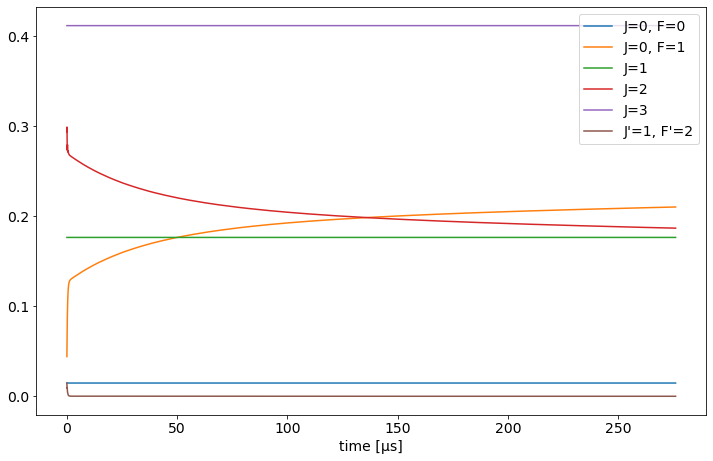

In [182]:
P0_singlet = pop_results[0,:]
P0_triplet = pop_results[1:4,:].sum(axis = 0)

P1 = pop_results[4:16,:].sum(axis = 0)
P2 = pop_results[16:36,:].sum(axis = 0)
P3 = pop_results[36:-5,:].sum(axis = 0)
Pe = pop_results[-5,:]

fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, P0_singlet, label = r'J=0, F=0')
ax.plot(t_array, P0_triplet, label = r'J=0, F=1')
ax.plot(t_array, P1, label = r'J=1')
ax.plot(t_array, P2, label = 'J=2')
ax.plot(t_array, P3, label = 'J=3')
ax.plot(t_array, Pe, label = "J'=1, F'=2")

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Parameter scan for RC Laser Power

In [203]:
Main.eval("""
@everywhere params = [val*Γ for val in range(0,1,length = 201)]""")

In [204]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [205]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [206]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; νp1; Δ1])
end
""")

In [207]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [208]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

156.1035826

In [209]:
results_Ω = np.array(Main.eval("sim.u"))

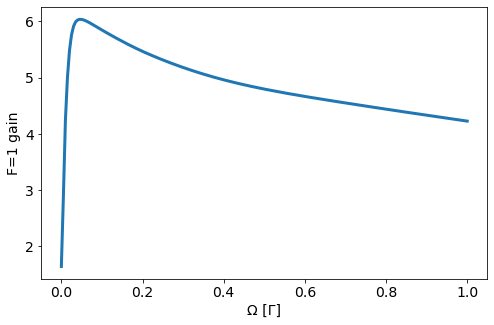

In [211]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ω[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('F=1 gain')

set_fontsize(ax, 14)

## Change main transition
## Total Internal Hamiltonian

In [212]:
H_X_red[np.abs(H_X_red) < 0.1] = 0
H_B_red[np.abs(H_B_red) < 0.1] = 0

H_int = scipy.linalg.block_diag(H_X_red, H_B_red)
V_ref_int = np.eye(H_int.shape[0])

#Define Hamiltonian in the rotating frame (transformation not applied yet)
H_rot = H_int.copy()

#Define QN for the total Hamiltonian that includes both X and B
QN = ground_states + excited_states

## Laser coupling
### Calculating transition 1; P(2), F$_1$'=3/2, F'=2

In [213]:
#Define ground states for laser driven transition
Js = [2]
ground_states_laser_approx =  [1*CoupledBasisState(F,mF,F1,J,I_F,I_Tl, electronic_state='X', P = (-1)**J, Omega = 0)
                                  for J  in Js
                                  for F1 in ni_range(np.abs(J-I_F),J+I_F+1)
                                  for F in ni_range(np.abs(F1-I_Tl),F1+I_Tl+1)
                                  for mF in ni_range(-F, F+1)
                                 ]

#Define excited states for laser
# excited_states_laser_approx = [1*CoupledBasisState(
#                                 F=0,mF=0,F1=1/2,J=1,I1=1/2,I2=1/2,P = +1, Omega = 1, electronic_state='B'
#                                 )
#                             ]
excited_states_laser_approx = excited_states_approx

In [214]:
#Define the "main" states. These are used to calculate the detunings and Rabi rates for the transitions
ground_main_approx = 1*CoupledBasisState(J=2,F1=5/2,F=2,mF=1,I1=1/2,I2=1/2,electronic_state='X', P = +1, Omega = 0)
excited_main_approx = 1*CoupledBasisState(J=1,F1=3/2,F=2,mF=1,I1=1/2,I2=1/2, electronic_state='B', P = -1, Omega = 1)

In [216]:
ground_states_laser_1 = find_exact_states(
                                ground_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )
excited_states_laser_1 = find_exact_states(
                                excited_states_laser_approx, H_rot, QN, V_ref = V_ref_int
                                )

H_laser_z_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([0,0,1]), 
                                    reduced = False
                                    )
H_laser_x_1 = optical_coupling_matrix(
                                    QN, 
                                    ground_states_laser_1, 
                                    excited_states_laser_1, 
                                    pol_vec = np.array([1,0,0]), 
                                    reduced = False
                                    )

In [217]:
# set small values to zero
H_laser_z_1[np.abs(H_laser_z_1) < 1e-3*np.max(np.abs(H_laser_z_1))] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-3*np.max(np.abs(H_laser_x_1))] = 0
H_laser_z_1[np.abs(H_laser_z_1) < 1e-6] = 0
H_laser_x_1[np.abs(H_laser_x_1) < 1e-6] = 0

In [218]:
ground_main_1 = find_exact_states([ground_main_approx], H_rot, QN, V_ref = V_ref_int)[0]
excited_main_1 = find_exact_states([excited_main_approx], H_rot, QN, V_ref = V_ref_int)[0]

ME_main_1 = ED_ME_mixed_state(
                        excited_main_1, ground_main_1, pol_vec = np.array([0,0,1])
                        )

ground_main_idx_1 = QN.index(ground_main_1)
excited_main_idx_1 = QN.index(excited_main_1)

print(ME_main_1)
ground_main_approx.print_state()
print('-'*100)
ground_main_1.print_state()
print('='*100)
excited_main_approx.print_state()
print('-'*100)
excited_main_1.print_state()

(0.06867255230474326+0j)
+1.0000+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
----------------------------------------------------------------------------------------------------
+0.9983+0.0000j x |X, J = 2, F1 = 5/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = 1, Omega = 0>
+1.0000+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
----------------------------------------------------------------------------------------------------
+0.8482+0.0000j x |B, J = 1, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>
+0.5294+0.0000j x |B, J = 2, F1 = 3/2, F = 2, mF = 1, I1 = 1/2, I2 = 1/2, P = -1, Omega = 1>


In [219]:
D1 = generate_laser_D(H_rot, QN, ground_main_1, excited_main_1, excited_states_laser_1, Δ = 0)

## Total Hamiltonian

In [220]:
H_rot = H_rot  - np.eye(H_rot.shape[0])*H_rot[ground_main_idx_1,ground_main_idx_1]
H_rot = H_rot + D1

In [221]:
Γ = 2*np.pi*1.6e6
C_list = collapse_matrices(QN, ground_states, excited_states, gamma = Γ)
C_array = np.array(C_list)
C_conj_array = np.einsum('ijk->ikj', C_array.conj())

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]


## Generate Symbolic Hamiltonian

In [222]:
t = Symbol("t", real = True)
Px1 = Function("Px1")(t) # Polarization switching function for x
Pz1 = Function("Pz1")(t) # Polarization switching function for z

laser_fields = [(H_laser_z_1*Pz1, ME_main_1), (H_laser_x_1*Px1, ME_main_1)]
detunings = [[QN.index(excited_states[0])]]

In [223]:
n_states = H_laser_z_1.shape[0]
excited_state_indices = [QN.index(exc_state) for exc_state in excited_states]
H_symbolic, Ωs = generate_symbolic_hamiltonian(n_states, laser_fields)
Δ_symbolic, Δs = generate_symbolic_detunings(n_states, detunings)
H_symbolic += Δ_symbolic + H_rot

In [224]:
H_symbolic = H_symbolic.subs(Ωs[1][0],Ωs[0][0]).subs(Ωs[1][1],Ωs[0][1])

In [225]:
system = generate_system_of_equations(H_symbolic, C_array, progress = True)

100%|██████████████████████████████████████████████████████████████████████████████████| 57/57 [43:32<00:00, 45.83s/it]


In [226]:
# convert matrix to system of equations code
code_lines = system_of_equations_to_lines(system)

## Creating the Julia function to compute the RHS of the Lindblad Equation
Note that only here the polarization switching function is added.  
Anything added symbolically can be modified here.

In [227]:
ode_fun = """function Lindblad_rhs!(du, ρ, p, t)
\t@inbounds begin
\t\tΩ1 = p[1]
\t\tνp1 = p[2]
\t\tΔ = p[3]
\t\tΩ1ᶜ = conj(Ω1)
\t\tPx1 = sine_wave(t, νp1, 4.71238898038469)
\t\tPz1 = sine_wave(t, νp1, 1.5707963267948966)
\t\tnorm1 = sqrt(Px1^2+Pz1^2)
\t\tPx1 /= norm1
\t\tPz1 /= norm1
"""

In [228]:
print(ode_fun)

function Lindblad_rhs!(du, ρ, p, t)
	@inbounds begin
		Ω1 = p[1]
		νp1 = p[2]
		Δ = p[3]
		Ω1ᶜ = conj(Ω1)
		Px1 = sine_wave(t, νp1, 4.71238898038469)
		Pz1 = sine_wave(t, νp1, 1.5707963267948966)
		norm1 = sqrt(Px1^2+Pz1^2)
		Px1 /= norm1
		Pz1 /= norm1



In [229]:
for cline in code_lines:
    ode_fun += "\t\t"+cline+'\n'
ode_fun += '\t end \n \t nothing \n end'

In [230]:
# making the function in Julia
Main.eval(f"@everywhere {ode_fun}")

In [231]:
ρ_ini = np.zeros([n_states, n_states], dtype = complex)
np.fill_diagonal(ρ_ini[:n_states-1, :n_states-1], 1/(n_states-1))

In [232]:
Γ = 2*np.pi * 1.56e6
Ω1 = Γ
ωp1 = 2*np.pi*2e6 # 2 MHz
Δ1 = 0
ωp1 = 0*np.pi*2e6

νp1 = ωp1/(2*np.pi)

Main.Γ = Γ
Main.Ω1 = Ω1
Main.νp1 = νp1
Main.Δ1 = Δ1

Main.ρ_ini = ρ_ini

# setting up the parameters to send to the differential equation
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = Γ
    Δ1 = 0
    @eval νp1 = $νp1
    p = [Ω1, νp1, Δ1]
end
""")

In [233]:
%%time
du = np.zeros(ρ_ini.shape, dtype = 'complex')
Main.du = du
Main.eval("""
Lindblad_rhs!(du, ρ_ini, p, 0.)
tmp = 0
""")

Wall time: 4min 43s


0

### Setting up the ODE problem to solve
`tmp = 0` is just to prevent `Main.eval` from outputting the problem in the notebook.  
The ODEProblem takes a function to solve (`Lindblad_rhs!` in this case), initial conditions `ρ_ini`, a timespan `tspan` an additional arguments for the ODE function, denoted here by `p` 

In [234]:
Main.eval("""
@everywhere begin
    Γ = 2pi*1.56e6
    Ω1 = 0.5*Γ
    Δ1 = 0
    @eval νp1 = $νp1
    p = [Ω1, νp1, Δ1]
end
""")

In [235]:
Main.eval("""
tspan = (0.0, 2*25.4/1e3 / 184)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
""");

In [236]:
%%time
Main.eval("""
@time sol = solve(prob, Tsit5(), abstol = 1e-15, reltol = 1e-12, dt = 1e-12)
tmp = 0
""");

Wall time: 15 s


0

In [237]:
ut = np.array(Main.eval("sol[:]")).T
pop_results = np.real(np.einsum('jji->ji',ut.reshape((ρ_ini.shape[0], ρ_ini.shape[1], ut.shape[2]))))
t_array = Main.eval("sol.t") * 1e6

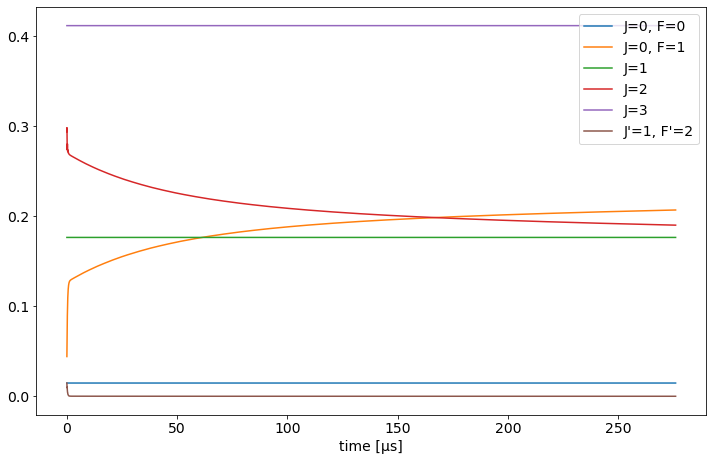

In [238]:
P0_singlet = pop_results[0,:]
P0_triplet = pop_results[1:4,:].sum(axis = 0)

P1 = pop_results[4:16,:].sum(axis = 0)
P2 = pop_results[16:36,:].sum(axis = 0)
P3 = pop_results[36:-5,:].sum(axis = 0)
Pe = pop_results[-5,:]

fig, ax = plt.subplots(figsize = (12,7.5))
ax.plot(t_array, P0_singlet, label = r'J=0, F=0')
ax.plot(t_array, P0_triplet, label = r'J=0, F=1')
ax.plot(t_array, P1, label = r'J=1')
ax.plot(t_array, P2, label = 'J=2')
ax.plot(t_array, P3, label = 'J=3')
ax.plot(t_array, Pe, label = "J'=1, F'=2")

ax.set_xlabel('time [μs]')
ax.legend(fontsize = 14)
set_fontsize(ax, 14)

## Parameter scan for RC Laser Power

In [239]:
Main.eval("""
@everywhere params = [val*Γ for val in range(0,1,length = 201)]""")

In [240]:
# function called every time on the when an ODE solve is ready
# only save the integral of the excited state population of each trajectory
Main.eval(f"""
@everywhere function output_func(sol,i)
    return [real(sol.u[end][j,j]) for j in 1:size(sol.u[end])[1]], false
end""")

In [241]:
Main.eval("""
tspan = (0.0f0, 300e-6)
prob = ODEProblem(Lindblad_rhs!,ρ_ini,tspan,p)
tmp = 0
""")

0

In [242]:
# defining the function that changes the ODE parameters for each iteration
Main.eval("""
@everywhere function prob_func(prob,i,repeat)
    remake(prob,p=[params[i]; νp1; Δ1])
end
""")

In [243]:
# setting up the EnsembleProblem with the earlier defined ODEProblem
Main.eval("""
ens_prob = EnsembleProblem(prob, prob_func = prob_func, output_func = output_func);
""")

<PyCall.jlwrap EnsembleProblem with problem ODEProblem>

In [244]:
# Main.eval("pbar.counter = 0")
# Main.eval("pbar.n = size(params)[1]")
Main.eval("""
@time sim = solve(ens_prob, Tsit5(), EnsembleDistributed(), save_start = true, save_end = true, 
            save_everystep = true; trajectories = size(params)[1], dt = 1e-9, adaptive=true,
            abstol = 5e-7, reltol = 5e-4)
sim.elapsedTime
""")

526.123155799

In [245]:
results_Ω_other = np.array(Main.eval("sim.u"))

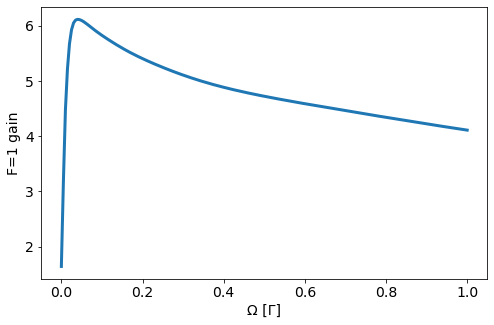

In [246]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, results_Ω_other[:,1:4].sum(axis = 1)/np.diag(ρ_ini.real)[1:4].sum(), lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('F=1 gain')

set_fontsize(ax, 14)

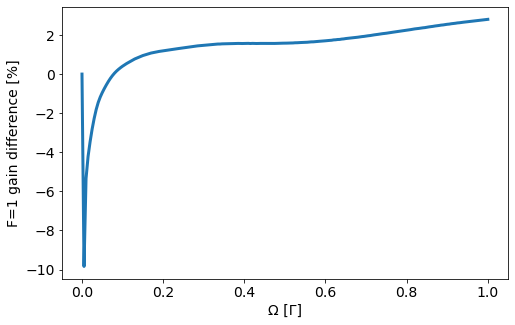

In [249]:
fig, ax = plt.subplots(figsize = (8,5))

ax.plot(Main.params/Γ, 100*(results_Ω[:,1:4].sum(axis = 1) - results_Ω_other[:,1:4].sum(axis = 1))/results_Ω[:,1:4].sum(axis = 1), lw = 3)
ax.set_xlabel('Ω [Γ]')
ax.set_ylabel('F=1 gain difference [%]')

set_fontsize(ax, 14)